In [1]:
import pdb
from diffuse.sde import SDE, SDEState, LinearSchedule
from diffuse.neural_networks import MLP
from diffuse.score_matching import score_match_loss
from jaxtyping import PyTreeDef, PRNGKeyArray
import jax.numpy as jnp
import jax
from typing import Callable
import einops
import optax
from tqdm import tqdm
from diffuse.mixture import init_mixture, sampler_mixtr
%load_ext autoreload
%autoreload 2

In [ ]:
model = MLP([200, 300, 1])
x = jnp.ones((1, 1))
t = jnp.ones((1, 1))
init = model.init(jax.random.PRNGKey(0), x, t)
res = model.apply(init, x, t)

beta = LinearSchedule(b_min=0.02, b_max=5.0, t0=0.0, T=2.0)

sde = SDE(beta)
key = jax.random.PRNGKey(0)

n_samples = 500
mixt_state = init_mixture(key)
samples_mixt = sampler_mixtr(key, mixt_state, n_samples)

ls = score_match_loss(
    init, key, samples_mixt, sde, 200, 2.0, lambda x: jnp.ones(x.shape[0]), model
)
jax.config.update("jax_debug_nans", True)

@jax.jit
def loss_(nn_params, key):
    samples_mixt = sampler_mixtr(key, mixt_state, n_samples)
    return score_match_loss(
        nn_params,
        key,
        samples_mixt,
        sde,
        500,
        2.0,
        lambda x: jnp.ones(x.shape),
        model,
    ).squeeze()

tx = optax.adam(1e-4)

@jax.jit
def train_step(nn_params, opt_state, key):
    g = jax.grad(loss_)(nn_params, key)
    updates, new_state = tx.update(g, opt_state)
    return updates, new_state

opt_state = tx.init(init)
nn_params = init
key = jax.random.PRNGKey(0)
losses = []
for i in tqdm(range(1000)):
    key, subkey = jax.random.split(key)
    updates, opt_state = train_step(nn_params, opt_state, subkey)
    nn_params = optax.apply_updates(nn_params, updates)
    losses.append(loss_(nn_params, key))

    

In [ ]:
loss_(nn_params, key)

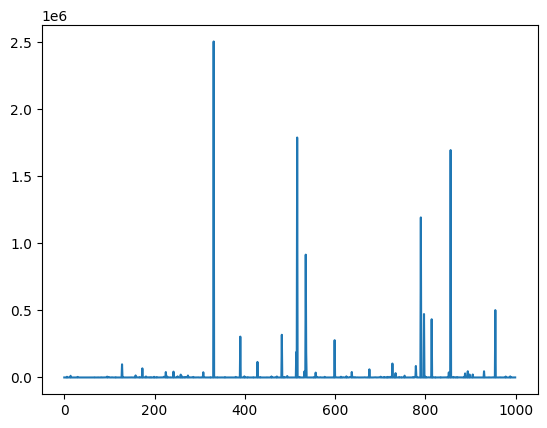

In [5]:
import matplotlib.pyplot as plt
plt.plot(losses)

In [ ]:
import jax
import jax.numpy as jnp
import pdb
import matplotlib.pyplot as plt
import einops
from diffuse.unet import UNet
from diffuse.score_matching import score_match_loss
from diffuse.sde import SDE, LinearSchedule
from functools import partial
import optax
from tqdm import tqdm

data = jnp.load("dataset/mnist.npz")
key = jax.random.PRNGKey(0)
xs = data["X"]
batch_size = 2

xs = jax.random.permutation(key, xs, axis=0)
data = einops.rearrange(xs, "b h w -> b h w 1")
# plt.imshow(data[0], cmap='gray')
# plt.show()
dt = jnp.linspace(0, 2.0, 200)
dt = jnp.array([2.0 / 200] * batch_size)

beta = LinearSchedule(b_min=0.02, b_max=5.0, t0=0.0, T=2.0)
sde = SDE(beta)

nn_unet = UNet(dt, 64)
init_params = nn_unet.init(key, data[:batch_size], dt)

def weight_fun(t):
    int_b = sde.beta.integrate(t, 0).squeeze()
    return 1 - jnp.exp(-int_b)

loss = partial(score_match_loss, lmbda=jax.vmap(weight_fun), network=nn_unet)



n_epochs = 40

nsteps_per_epoch = data.shape[0] // n_epochs
until_steps = int(0.95 * n_epochs) * nsteps_per_epoch
lr = 2e-4
schedule = optax.cosine_decay_schedule(init_value=lr, decay_steps=until_steps, alpha=1e-2)
optimizer = optax.adam(learning_rate=schedule)
ema_kernel = optax.ema(0.99)

@jax.jit
def step(key, params, opt_state, ema_state, data):
    val_loss, g = jax.value_and_grad(loss)(params, key, data, sde, 100, 2.0)
    updates, opt_state = optimizer.update(g, opt_state)
    params = optax.apply_updates(params, updates)
    ema_params, ema_state = ema_kernel.update(params, ema_state)
    return params, opt_state, ema_state, val_loss, ema_params

params = init_params
opt_state = optimizer.init(params)
ema_state = ema_kernel.init(params)

for epoch in range(n_epochs):
    subkey, key = jax.random.split(key)
    data = jax.random.permutation(subkey, data, axis=0)
    p_bar = tqdm(range(nsteps_per_epoch))
    for i in p_bar:
        subkey, key = jax.random.split(key)
        params, opt_state, ema_state, val_loss, ema_params = step(subkey, params, opt_state, ema_state, data[i:i+batch_size])
        p_bar.set_postfix({"loss=": val_loss})


  0%|          | 0/1500 [00:00<?, ?it/s]

In [66]:
nn_unet = UNet(dt, 64, upsampling="pixel_shuffle")
dict_param = nn_unet.init(key, jnp.ones((batch_size, 28, 28, 1)), jnp.ones((batch_size, )))
#init_params = nn_unet.init(key, data[:batch_size], dt)
array_param, array_to_dict = jax.flatten_util.ravel_pytree(dict_param)


In [2]:
import numpy as np
import jax
import jax.numpy as jnp
import pdb
import matplotlib.pyplot as plt
import einops
from diffuse.unet import UNet
from diffuse.score_matching import score_match_loss
from diffuse.sde import SDE, LinearSchedule
from functools import partial
import optax
import matplotlib.pyplot as plt
from tqdm import tqdm
#np.savez("ann.npz", params=params, ema_params=ema_params)

In [3]:
nn_trained = jnp.load("ann_2999.npz", allow_pickle=True)
nn_params = nn_trained["params"].item()
array_param, array_to_dict = jax.flatten_util.ravel_pytree(nn_params)

#nn_trained = jnp.load("mnist_lin_2999.npz", allow_pickle=True)
#nn_params = nn_trained["param"]
#nn_params = array_to_dict(nn_params)



In [4]:
data = jnp.load("dataset/mnist.npz")
key = jax.random.PRNGKey(0)
xs = data["X"]
tf = 2.0
batch_size = 256
n_epochs = 3000
n_t = 256
dt = tf / n_t


xs = jax.random.permutation(key, xs, axis=0)
data = einops.rearrange(xs, "b h w -> b h w 1")
nn_unet = UNet(dt, 64, upsampling="pixel_shuffle")

In [5]:
def nn_score(x, t):
    return nn_unet.apply(nn_params, x, t)

In [6]:
n_steps = 500
rng_key = jax.random.PRNGKey(0)

ts = jnp.array([tf])
dts = jnp.array([2.0 / n_steps] * (n_steps))

beta = LinearSchedule(b_min=0.02, b_max=5.0, t0=0.0, T=2.0)
sde = SDE(beta=beta)

init_samples = jax.random.normal(rng_key, data[0].shape)
state_f = SDEState(position=init_samples, t=ts)

revert_sde = partial(sde.reverso, score=nn_score, dts=dts)
state_0, state_Ts = revert_sde(rng_key, state_f)

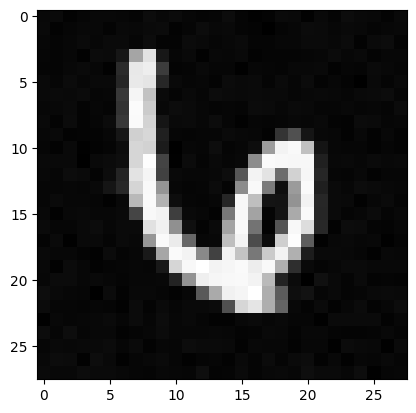

In [7]:
plt.imshow(state_Ts.position[-1], cmap="gray")
plt.show()

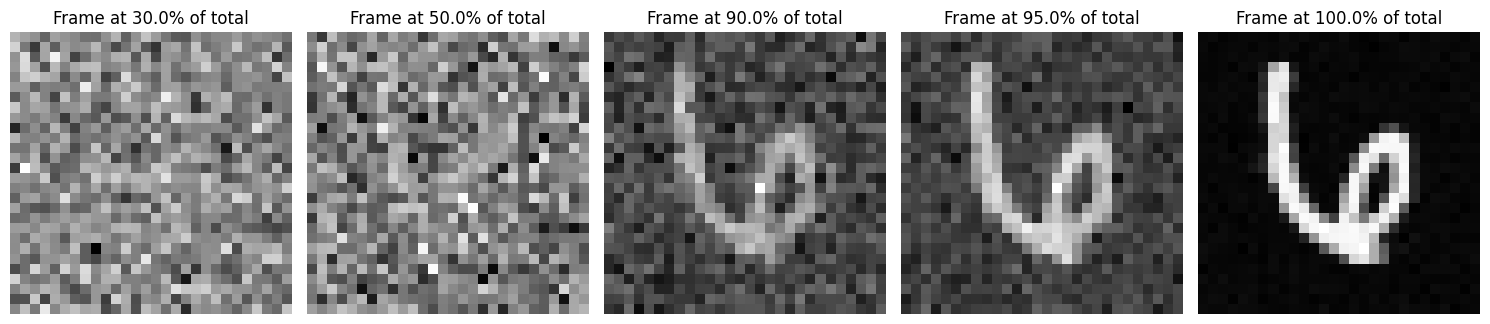

In [11]:
total_frames = len(state_Ts.position)

# Define the fractions
fractions = [0.3, 0.5, 0.9, .95, 1.]

# Create a figure with subplots
fig, axs = plt.subplots(1, 5, figsize=(15, 5))

for idx, fraction in enumerate(fractions):
    # Calculate the frame index
    frame_index = int(fraction * total_frames)
    
    # Plot the image
    axs[idx].imshow(state_Ts.position[frame_index], cmap="gray")
    axs[idx].set_title(f"Frame at {fraction*100}% of total")
    axs[idx].axis('off')  # Turn off axis labels

plt.tight_layout()
plt.show()

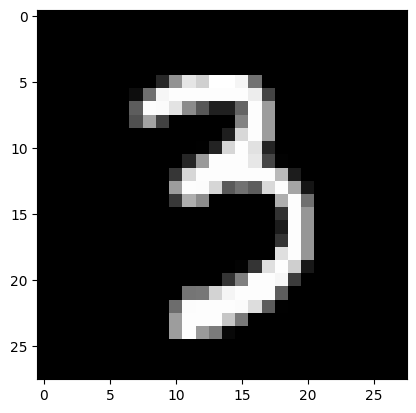

In [30]:
plt.imshow(data[10], cmap="gray")
plt.show()

In [42]:
nn_trained = jnp.load("mnist_lin_2999.npz", allow_pickle=True)

In [44]:
nn_trained["ema_param"]

array([-0.0035706 , -0.05850521, -0.00155016, ..., -0.06112844,
        0.05872548,  0.04008726], dtype=float32)

In [ ]:
j